<div align="right"><i>Peter Norvig, Oct 2017<br>Revised Jan 2020</i></div>

# Bicycling: Speed v. Grade, VAM, Eddington,  Hill-index

Like most people, I bike slower when I'm going up a steep hill than on a flat road. But how much slower?
To answer that, I downloaded a bunch of my recorded [Strava](https://www.strava.com/athletes/575579) rides longer than 25 miles as [`bikerides25.tsv`](bikerides25.tsv).  I parse the file into `rides`, a list of `Ride` structures. I filter out all the rides that have exactly 0 ft climbing (i.e. stationary bike rides) or that have `'MTB'` in the title (i.e. mountain bike rides that are not relevant to road bike riding) or are blank or are comment lines (start with `#`).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import re
from collections import namedtuple

Ride = namedtuple('Ride', 'miles, hours, feet, date, title')

def parse_ride(line: str) -> Ride:
    """Parse a line from a Strava log file into a `Ride`. Line format is tab separated:
    Ride	Thu, 8/9/2018	BRNW	4:58:07	68.41 mi	3,862 ft"""
    _, date, title, time, mi, ft = line.strip().split('\t')
    return Ride(number(mi), hours(*time.split(':')[::-1]), number(ft), date, title)

def number(string) -> float: return float(re.sub(r'[^0-9. ]', '', string))

def hours(sec, min, hour=0) -> float: return int(sec)/3600 + int(min)/60 + int(hour)

rides = [parse_ride(line) for line in open('bikerides25.tsv') 
         if line.strip() and not line.startswith('#') and 'MTB' not in line and '	0 ft' not in line]

From the raw data I will derive three important vectors of numbers: 
- `mls`: length of ride in miles
- `mph`: speed in miles per hour
- `fpm`: grade in feet climbed per mile

I'll show a simple scatter plot  visualization:

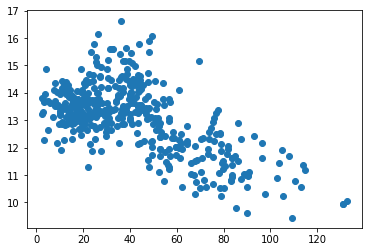

In [2]:
def vectors3(rides) -> tuple:
    "Return vectors of (miles, miles/hour, feet/mile)"
    return ([r.miles           for r in rides],
            [r.miles / r.hours for r in rides],
            [r.feet  / r.miles for r in rides])

mls, mph, fpm = vectors3(rides)

plt.scatter(fpm, mph);

# Making it Prettier

As expected, there is a lot of variance, but overall speeds get slower as the grade gets steeper. Just eyeballing the scatter plot, it looks like some kind of downward sloping curve would be a better fit than a straight line, so I'll fit quadratic (degree two) and cubic (degree 3) polynomials to the data (for no good theoretical reason; just because those are the two simplest nonlinear functions I could think of). I'll also make the plot prettier and bigger:

In [3]:
def show(X, Y, xlabel='Grade (feet/mile)', ylabel='Speed (mph)', degrees=(2, 3)): 
    "Plot X versus Y and a best fit curve to it, with some bells and whistles."
    plt.rcParams["figure.figsize"] = (12, 10)
    plt.style.use('fivethirtyeight')
    grid(); plt.ylabel(ylabel); plt.xlabel(xlabel)
    plt.scatter(X, Y, c='k')
    X1 = np.linspace(min(X), max(X), 100)
    for degree in degrees:
        F = poly_fit(X, Y, degree)
        plt.plot(X1, [F(x) for x in X1], '-', lw=2)
    plt.title(f'{len(X)} rides')

def grid(): plt.minorticks_on(); plt.grid(which='minor', ls=':', alpha=0.7)
    
def poly_fit(X, Y, degree) -> callable:
    """The polynomial function that best fits the X,Y vectors."""
    coeffs = np.polyfit(X, Y, degree)[::-1]
    return lambda x: sum(c * x ** i for i, c in enumerate(coeffs))         

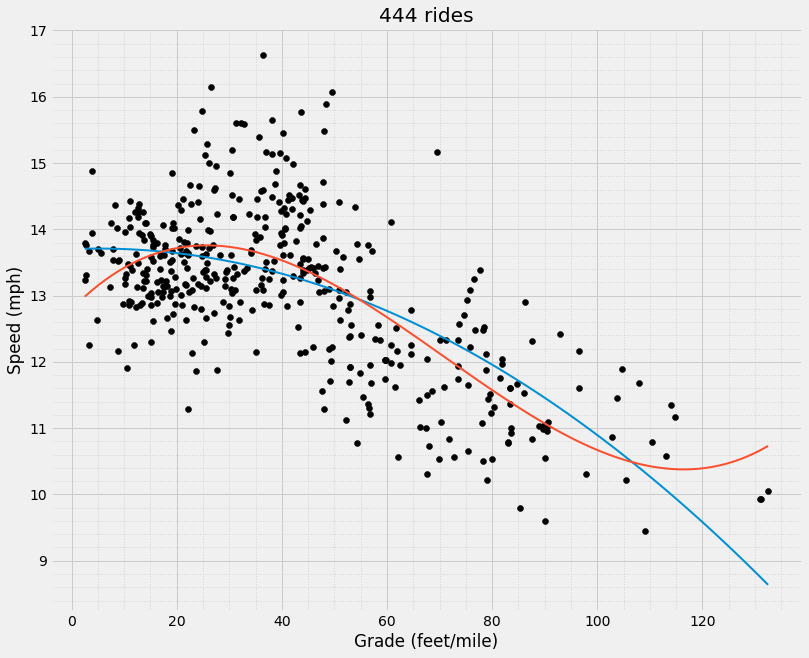

In [4]:
show(fpm, mph)

So, I average a little under 14 mph when the overall route is fairly flat, with a lot of variability from 12 to 16 mph, depending more on my level of effort than on the grade of the road. But from around 50 ft/mile grade speed falls off quickly: down to 12mph at 80 ft/mile;  11 mph at 100 ft/mile; and around 10 mph at 120 ft/mile. Note that even 120 ft/mile is only 2.3% grade, but if you figure a typical route is 1/3 up, 1/3 down, and 1/3 flat, then that's 6.9% average grade on the up part.

# Estimating Duration

This data can help me predict how long will it take to ride a route with a given distance and elevation. For example, to get to  Pescadero from La Honda, I could take the flatter [coast route](https://www.google.com/maps/dir/La+Honda,+California/Pescadero,+California/@37.2905834,-122.3896683,12z/data=!4m19!4m18!1m10!1m1!1s0x808faed4dc6265bd:0x51a109d3306a7219!2m2!1d-122.274227!2d37.3190255!3m4!1m2!1d-122.4039496!2d37.3116594!3s0x808f062b7d7585e7:0x942480c22f110b74!1m5!1m1!1s0x808f00b4b613c4c1:0x43c609077878b77!2m2!1d-122.3830152!2d37.2551636!3e1) (15.7 miles, 344 ft climb), or the shorter [creek route](https://www.google.com/maps/dir/La+Honda,+California/Pescadero,+California/@37.2905834,-122.3896683,12z/data=!4m19!4m18!1m10!1m1!1s0x808faed4dc6265bd:0x51a109d3306a7219!2m2!1d-122.274227!2d37.3190255!3m4!1m2!1d-122.3658887!2d37.2538867!3s0x808f00acf265bd43:0xb7e2a0c9ee355c3a!1m5!1m1!1s0x808f00b4b613c4c1:0x43c609077878b77!2m2!1d-122.3830152!2d37.2551636!3e1) (13.5 miles, 735 ft climb); which is faster?

In [5]:
def duration(dist, climb, F=poly_fit(fpm, mph, 2)) -> float:
    "Given a distance in miles and total climb in feet, estimate time in minutes."
    return 60 * dist / F(climb / dist)

In [6]:
f'Coast: {duration(15.7, 344):.1f} min, Creek: {duration(13.5, 735):.1f} min.'

'Coast: 69.2 min, Creek: 62.5 min.'

This suggests the shorter creek route would be about 6 or 7 minutes faster. Good to know, but other factors (like the scenery) are probably more important in making the choice.

# Segments

The data I have so far helps me estimate the duration for a long ride over varying up-and-down terrain. But what if I just want to know how long it will take to climb the next hill? To answer that I'll go back to Strava and retrieve data from individual segments, some only a fraction of a mile long, some several miles long, but most with a relatively constant grade. I picked some representative climbing segments ([`bikesegments.csv`](bikesegments.csv)) with the segment length in miles and climb in feet, along with several of my times on the segment. (Strava shows my times for up to 10 rides on each segment; I picked the first, middle, and last of the rides shown.) 

In [7]:
def parse_segments(lines):
    """Parse a string of segments into Rides. Each line contains:
    'title, miles, feet, time(s)'."""
    for segment in lines:
        title, mi, ft, *times = segment.split(',')
        for time in times:
            time = hours(*time.split(':')[::-1])
            yield Ride(float(mi), time, int(ft), 'date?', title)
            
segments = set(parse_segments(open('bikesegments.csv')))

mls2, mph2, fpm2 = vectors3(segments)     

For the plot I will list grade in percent rather than feet per mile:

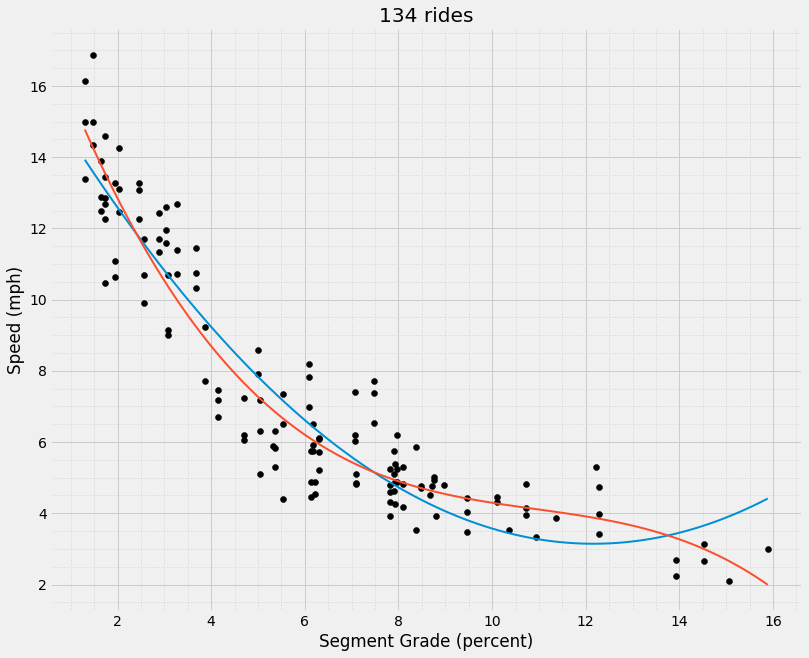

In [8]:
pct2 = [f * 100 / 5280 for f in fpm2]

show(pct2, mph2, xlabel='Segment Grade (percent)')  

So I can cruise at 16 or 17 mph on a 1% grade, but only about 8 mph at 5% grade, and around 5 mph on 8% grades.

# VAM

The number of vertical feet (or meters) climbed per hour (regardless of horizontal distance travelled) is known as [VAM](https://en.wikipedia.org/wiki/VAM_%28bicycling%29), which stands for *velocità ascensionale media* (for native Campagnolo speakers) or *mean ascent velocity* (for SRAM) or 平均上昇率 (for Shimano). The theory is that for medium-steepish climbs, most of your power is going into lifting against gravity, so your VAM should be about constant no matter what the grade in that range. (For flatish rides power is spent on wind and rolling resistance, and for super-steep rides power goes largely to cursing *sotto voce*, as they say in Italian.) Here's a plot of my VAM versus grades (in percent):

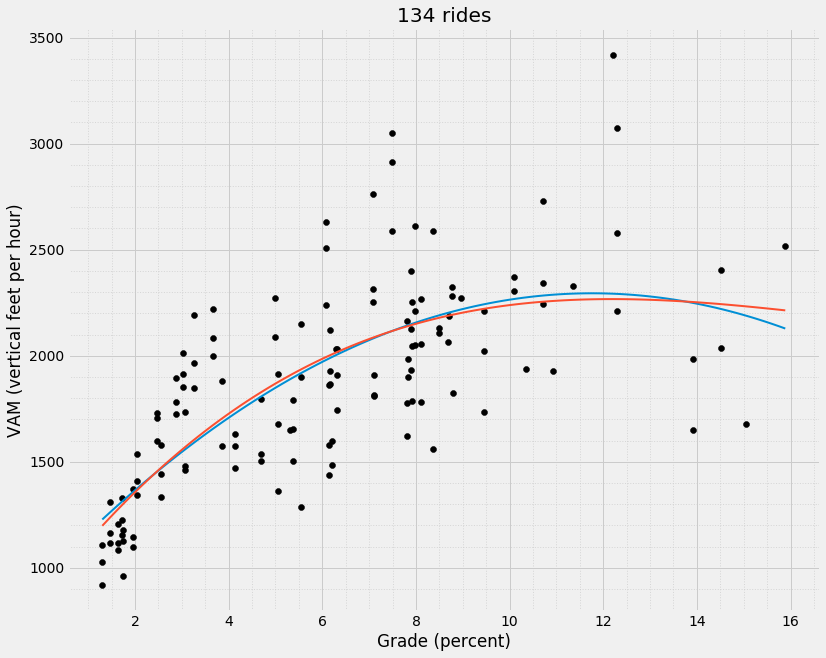

In [9]:
vam2 = [r.feet / r.hours for r in segments]

show(pct2, vam2, xlabel='Grade (percent)', ylabel='VAM (vertical feet per hour)')

I don't see the flattening effect; I see a wide spread of VAM numbers; at about 8% I range from 1500 to 3000 VAM. Champions can do  6000. 

Another way to look at it: at what speed am I getting the most VAM (implicitly assuming I'm giving a similar level of effort at all times, which is not really true)? The curve says 5 or 6 mph, but the data is pretty noisy.



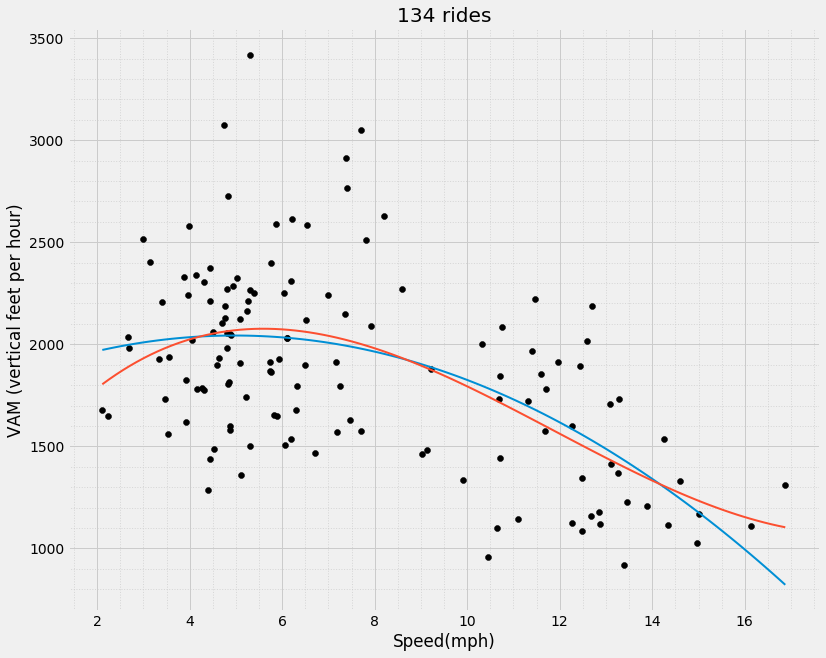

In [10]:
show(mph2, vam2, xlabel='Speed(mph)', ylabel='VAM (vertical feet per hour)')

# Hill-Index

Inspired by the [h-index](https://en.wikipedia.org/wiki/H-index) for scientific publications, I invented a new metric, the hill-index:

> *Your **hill-index** is the maximum number**&nbsp;h** for which you can regularly climb an**&nbsp;h** percent grade at **&nbsp;h** miles per hour.*

I think **my hill-index is 6**, but let's draw a plot to confirm:

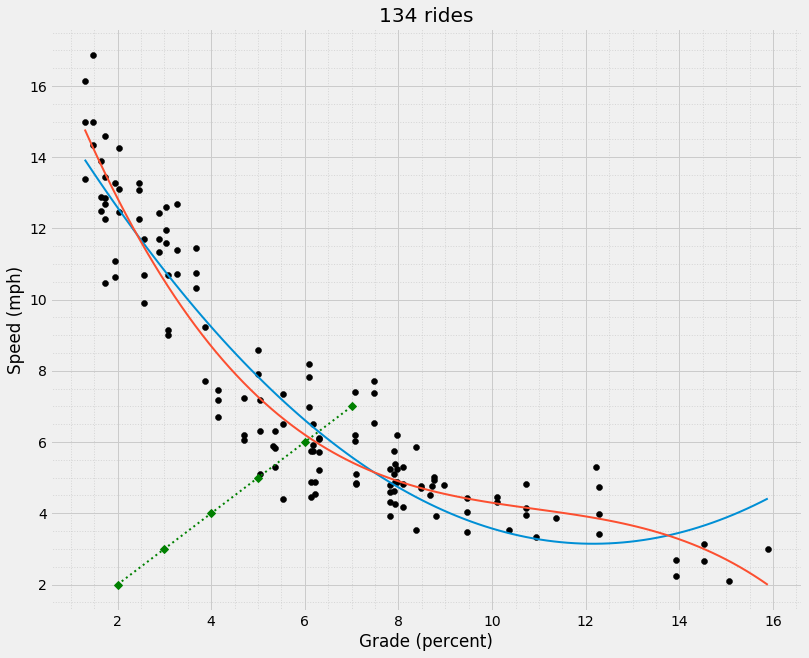

In [11]:
points = range(2, 8)
show(pct2, mph2, xlabel='Grade (percent)')  
plt.plot(points, points, 'gD:', lw=2);

The  green dotted line is where grade = speed, the red and blue lines are best-fit polynomials, and if I interpret "regularly" to mean "around half the time," then both best-fit lines are above the diamond at 6%, but both are below the diamond for 7%, so my guess is confirmed: my hill-index is 6.

Note that the original h-index for publications is based on cumulative totals, so it can never decrease, but the Hill-index is based on an average so it can (and sadly, often does) decrease as you grow older.



# Eddington Number

Speaking of h-numbers, the  physicist Sir Arthur Eddington (1882-1944) was a pre-Strava bicyclist who favored this metric:

> *Your [Eddington Number](https://www.triathlete.com/2011/04/training/measuring-bike-miles-eddington-number_301789) is the maximum integer**&nbsp;e** such that you have bicycled at least**&nbsp;e** miles on at least**&nbsp;e** days.*

Let's calculate mine:

In [12]:
def Eddington(distances) -> int:
    "Eddington number: the maximum integer e such that you have bicycled at least e on at least e days."
    return max(e for e in range(300) if days_at_least(e, distances) >= e)

def days_at_least(e, distances) -> int: return sum(d >= e for d in distances)

Eddington(mls)

56

My **Eddington Number is 56**: I've done at least 56 miles on at least 56 days. This is a bit above [the mean for Strava users](https://swinny.net/Cycling/-4687-Calculate-your-Eddington-Number). Eddington was 62 years old when he died with a number of **77**, and his available roads, bicycles, and navigation aids were not nearly as nice as mine, so good for him.

How many more rides would I need to improve my number? Obviously, for anyone to improve from, say, 56 to 60 they need at least 4 more rides.  But if some of their past rides were, say, 58 or 59 miles, then those counted for an Eddington number of 55 but they wouldn't count for 60; thus more than 4 rides would be needed. Here is a table of the number of rides I would need&mdash;what I'll call the *gap*&mdash;for increasingly ambitious Eddington numbers:

In [13]:
def Egaps(distances, rows):
    """Print the number of days doing various distances, and the Eddington gap."""
    print('Dist Days Gap')
    print('---- ---- ---')
    for dist in rows:
        days = days_at_least(dist, distances)
        print(f'{dist:4} {days:4} {dist - days:3}')
        
Egaps(mls, range(56, 71))

Dist Days Gap
---- ---- ---
  56   56   0
  57   53   4
  58   50   8
  59   44  15
  60   43  17
  61   37  24
  62   35  27
  63   33  30
  64   31  33
  65   28  37
  66   26  40
  67   22  45
  68   21  47
  69   16  53
  70   16  54


I'd like to get my Eddington number to meet or beat my age. If I really concentrate on long rides and do one 70+ mile ride every 2.5 weeks in 2020 and 2021, I can just barely get to Eddington number 65 at age 65; after that I'll have to do no more than six 70+ mile rides each year up until age 70. That sounds tough, but doable.

An easier way to get a bigger Eddington number is to use kilometers rather than miles:

In [14]:
kms = [m * 5280 * 12 * 2.54 / 100 / 1000 for m in mls]
Eddington(kms)

80

In [15]:
Egaps(kms, range(80, 101))

Dist Days Gap
---- ---- ---
  80   80   0
  81   77   4
  82   69  13
  83   68  15
  84   63  21
  85   62  23
  86   61  25
  87   59  28
  88   58  30
  89   57  32
  90   56  34
  91   54  37
  92   53  39
  93   50  43
  94   47  47
  95   44  51
  96   43  53
  97   40  57
  98   37  61
  99   35  64
 100   35  65


My **metric Eddington Number is 80**, and I should be able to get to 90 in two years, and 100 in four years, assuming one 100+ km ride every three weeks.